# Neogen Pesticide Analysis

# Background and Motivation:
To determine what foods contain pesticide residues or combinations of 
pesticide residues that exceed maximum residue limits, or may pose a concern for human and animal 
health.


## How the data was retrieved:

**The data for this project was gathered from the PDP Database, which is a national pesticide residue monitoring program and produces the most comprehensive pesticide residue database in the U.S.**
- The website https://www.ams.usda.gov/datasets/pdp has the database.

There is a link to the PDP Database Search where the data can be filtered for specific commodities, pesticides or years. For the purposes of this project, commodities and pesticides were gathered for all years. By checking the box for all commodities, all pesticides and all years, as well as setting the output preference to Analytical Results and the results preference to Positive Detects Only, the dataset can be downloaded. This gives the analytical results for only cases where there was a positive detect of pesticides. The analytical results output allows for analysis on the most relevant columns. From this point, once the data loads there is a button to Export to Excel. This will download the selected data as a csv file which can then be loaded into Python using the packages below.

### Importing packages and data:

In [1]:
import pandas as pd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import csv
import re
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
# Read in PDP data
df = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)

# Includes Data outside PDP Database:
PDP_Data = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)
FDA_2020 = pd.read_csv("CountryProductResidue2020.txt",delim_whitespace=True)
FAOPest_Amount = pd.read_csv('FAOSTAT_PestDataUS.csv')
FAOPest_Area = pd.read_csv('FAOSTAT_PestPerArea.csv')


#  Pesticides with the biggest impact on the environment in the next 3-5 years?


In [16]:
dates = []      #extract the dates from Sample ID
for i in range(len(df)):
    sample_id = df["Sample ID"][i]
    year = sample_id[2:4]
    if (int(year) < 90):
        year = '20'+ year
    else:
        year = '19' + year
    month = sample_id[4:6]
    day = sample_id[6:8]
    d = year + '-' + month + '-' + day
    date = pd.to_datetime(d)
    dates.append(date)
df["Date"] = dates
# Convert parts per trillion to parts per million where pp_ is 'T'
df.loc[df['pp_'] == 'T', 'Concentration'] = df['Concentration'] / 1000000
df.loc[df['pp_'] == 'T', 'LOD'] = df['LOD'] / 1000000
df.loc[df['pp_'] == 'T', 'pp_'] = 'M'
df = df.drop('Sample ID', axis=1)  #drop sample id
df.sort_values(by="Date", inplace=True)
df.head()

,Commod,Pesticide Code,Pesticide Name,Test Class,Concentration,LOD,pp_,Confirm 1,Confirm 2,Annotate,Quantitate,Mean,Extract,Determ,EPA Tolerance (ppm),Date
124746,CR,300,DDE,A,0.011,0.006,M,M,NaN,Q,M,O,NaN,NaN,3 AL,1994-01-03
169796,GB,164,Chlorothalonil,A,0.033,0.008,M,D,NaN,NaN,M,O,NaN,NaN,5,1994-01-03
169797,GB,115,Endosulfans Total,A,0.167,0.005,M,D,M,NaN,M,O,NaN,NaN,2,1994-01-03
169798,GB,115,Endosulfans Total,A,0.009,0.005,M,D,NaN,Q,M,O,NaN,NaN,2,1994-01-03
169799,GB,164,Chlorothalonil,A,0.260,0.008,M,D,M,NaN,M,O,NaN,NaN,5,1994-01-03


In [17]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exlude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
df["New EPA"] = numbers
df = df.dropna(subset=['New EPA'])
exceed = df[df.Concentration.gt(df["New EPA"])]
exceed.head()

,Commod,Pesticide Code,Pesticide Name,Test Class,Concentration,LOD,pp_,Confirm 1,Confirm 2,Annotate,Quantitate,Mean,Extract,Determ,EPA Tolerance (ppm),Date,New EPA
218717,GR,512,3-Hydroxycarbofuran,E,0.34,0.023,M,I,NaN,X,H,A,NaN,NaN,0.2,1994-01-11,0.2
53195,BN,604,Imazalil,N,0.36,0.030,M,M,NaN,X,H,A,NaN,NaN,0.2,1994-03-23,0.2
169382,GB,204,Acephate,C,3.30,0.005,M,M,NaN,X,M,A,NaN,NaN,3,1994-10-24,3.0
216358,GR,512,3-Hydroxycarbofuran,E,0.32,0.021,M,I,NaN,X,H,A,NaN,NaN,0.2,1995-01-03,0.2
411278,SP,171,Dimethoate,C,11.00,0.032,M,M,NaN,X,H,A,15,16.0,2,1995-04-11,2.0


Create a new dataset only containing the variables we need.

In [18]:
data = df[['Date','Pesticide Name', 'Concentration','New EPA']]
data = data.dropna(subset=['New EPA'])
data['Percent of Threshold'] = (data['Concentration'] / data['New EPA']) * 100
data.head()

,Date,Pesticide Name,Concentration,New EPA,Percent of Threshold
124746,1994-01-03,DDE,0.011,3.0,0.366667
169796,1994-01-03,Chlorothalonil,0.033,5.0,0.660000
169797,1994-01-03,Endosulfans Total,0.167,2.0,8.350000
169798,1994-01-03,Endosulfans Total,0.009,2.0,0.450000
169799,1994-01-03,Chlorothalonil,0.260,5.0,5.200000


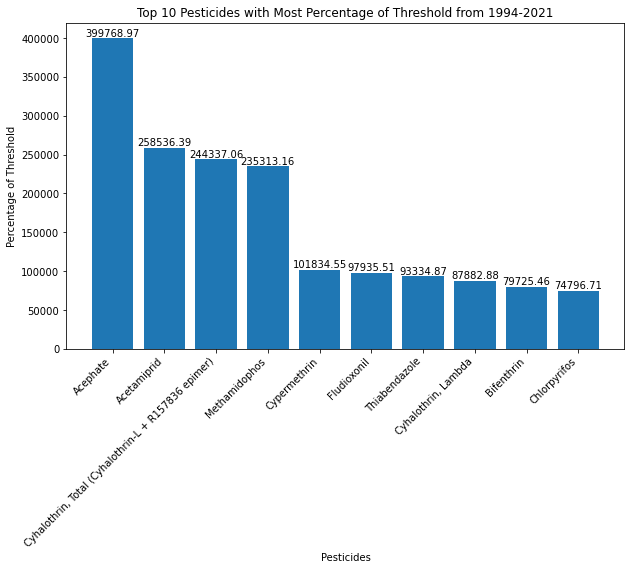

In [19]:
pest_sort = data.groupby('Pesticide Name')['Percent of Threshold'].sum()
pest_sort.sort_values(inplace=True,ascending=False)
top_pest = pest_sort.index[:10].values
plt.figure(figsize=(10,6))
plt.bar(top_pest, pest_sort.values[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Pesticides with Most Percentage of Threshold from 1994-2021")
plt.xlabel("Pesticides")
plt.ylabel("Percentage of Threshold")
for i, v in enumerate(pest_sort.values[:10]):
        plt.annotate("{:.2f}".format(v), xy=(i, v), xytext=(i, v+0.5),
                 ha='center', va='bottom')
plt.show()

In [20]:
df[df['Pesticide Name'] == 'Cyhalothrin, Lambda'].tail()

,Commod,Pesticide Code,Pesticide Name,Test Class,Concentration,LOD,pp_,Confirm 1,Confirm 2,Annotate,Quantitate,Mean,Extract,Determ,EPA Tolerance (ppm),Date,New EPA
398340,SN,AEM,"Cyhalothrin, Lambda",O,0.0033,0.002,M,GT,NaN,Q,NaN,O,805,35.0,0.2,2018-12-18,0.2
398350,SN,AEM,"Cyhalothrin, Lambda",O,0.0075,0.002,M,GT,NaN,NaN,NaN,O,805,35.0,0.2,2018-12-18,0.2
395442,SN,AEM,"Cyhalothrin, Lambda",O,0.0142,0.002,M,GT,NaN,NaN,NaN,O,805,35.0,0.2,2018-12-19,0.2
395454,SN,AEM,"Cyhalothrin, Lambda",O,0.0033,0.002,M,GT,NaN,Q,NaN,O,805,35.0,0.2,2018-12-19,0.2
395448,SN,AEM,"Cyhalothrin, Lambda",O,0.0336,0.002,M,GT,NaN,NaN,NaN,O,805,35.0,0.2,2018-12-19,0.2


**'Cyhalothrin, Lambda' do not have data after 2018 so we dropped those pesticides.**

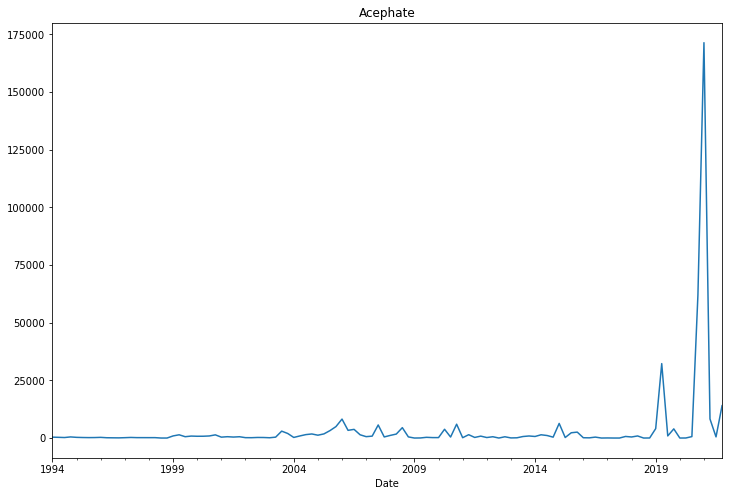

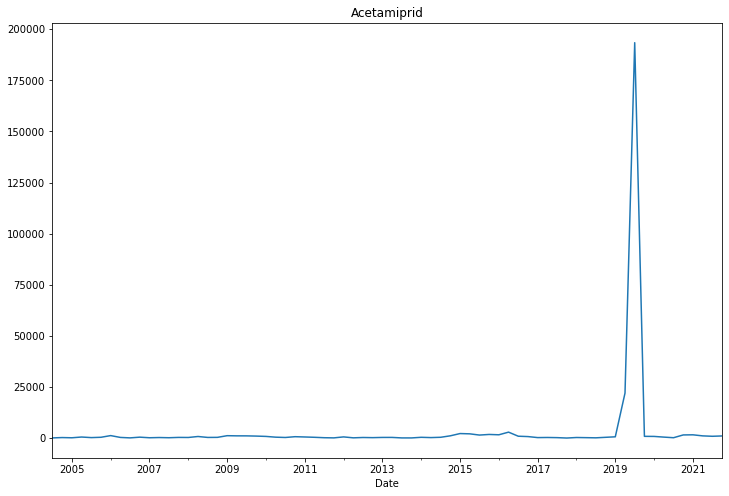

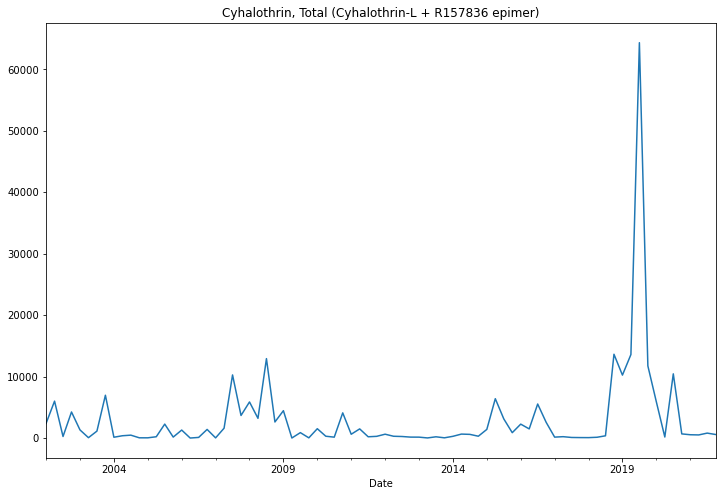

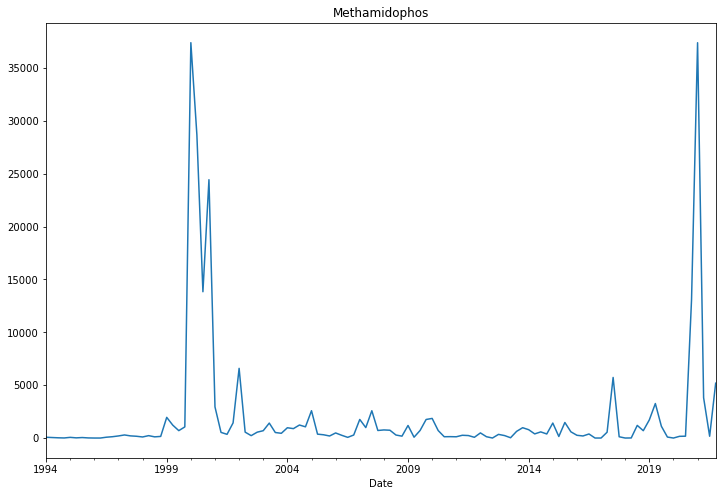

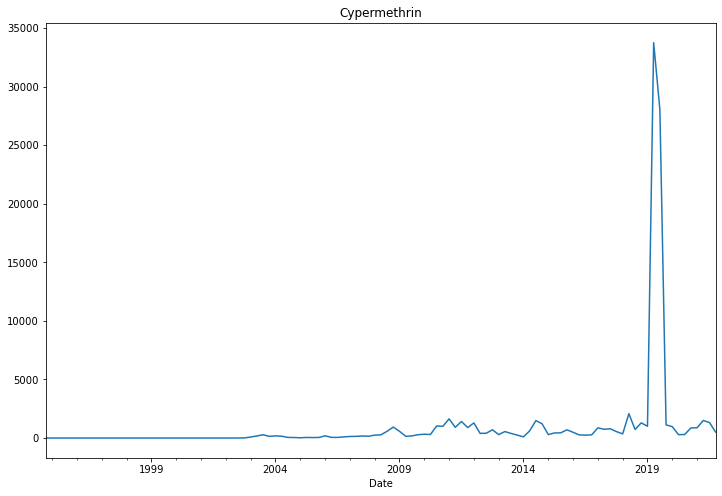

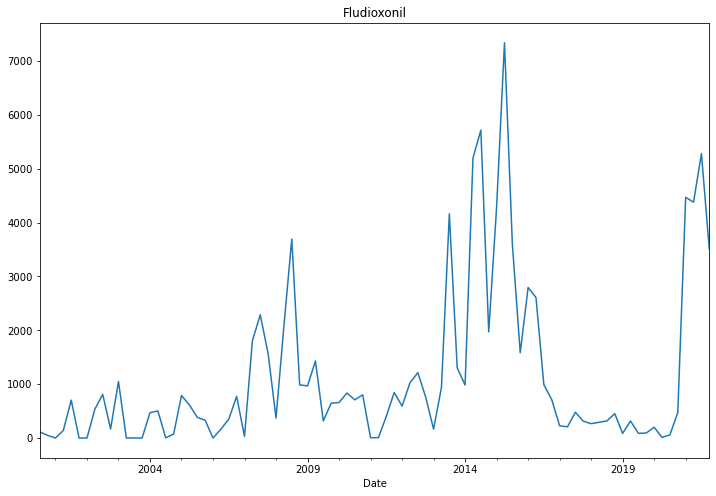

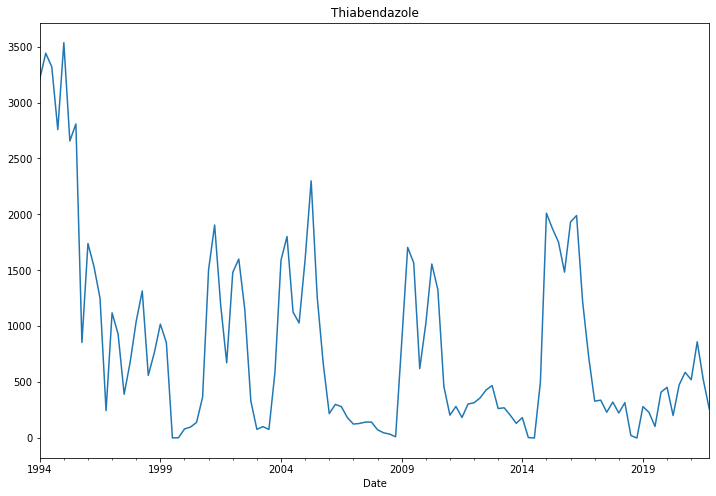

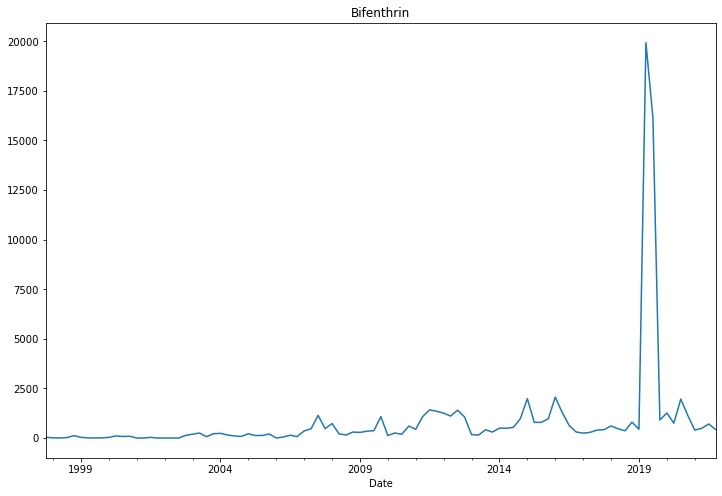

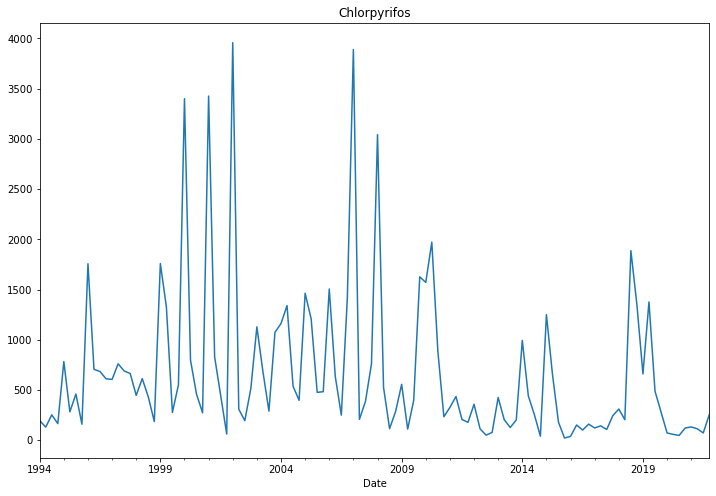

In [21]:
index = np.where(top_pest == 'Cyhalothrin, Lambda')[0]
top_pest = np.delete(top_pest, index)
for p in top_pest:
    top = data[data['Pesticide Name'] == p]
    top = top.set_index('Date')
    top = top.dropna()
    # create a time series with sesonal frequency
    ts = top['Percent of Threshold'].resample('Q').sum()
    ts.fillna(0, inplace=True)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ts.plot()
    plt.title(p)

Based on the trends of percentage of threshold, I'm going to remove some outliers from several pesticides before building the model

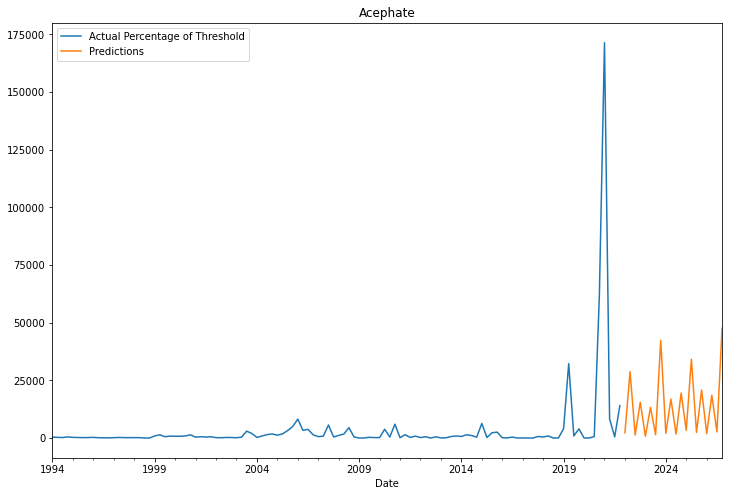

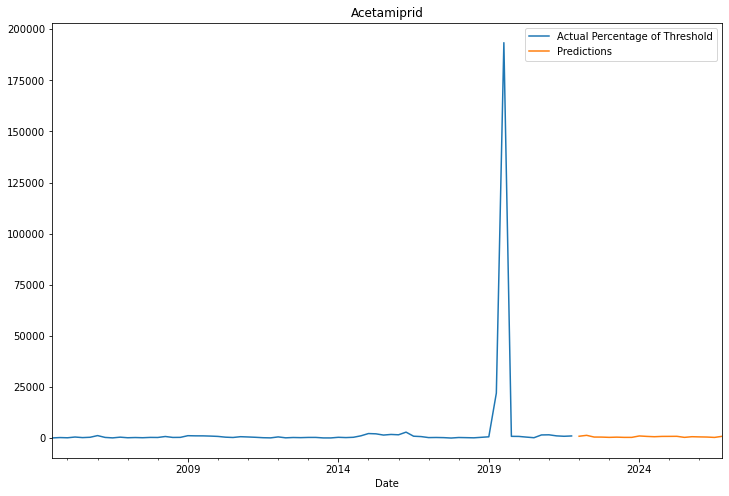

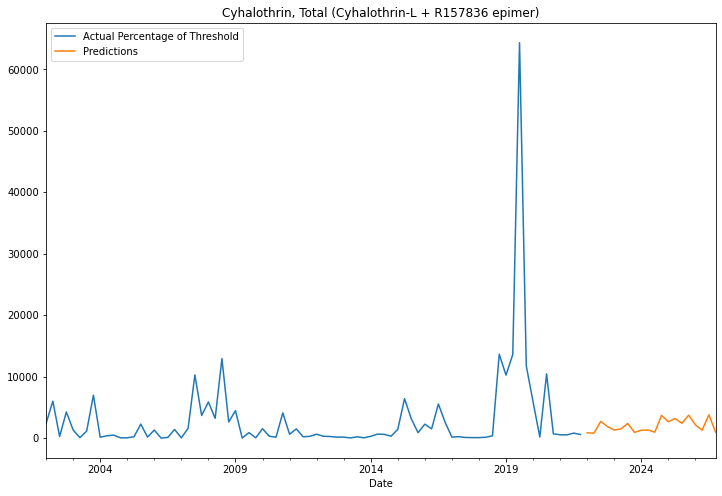

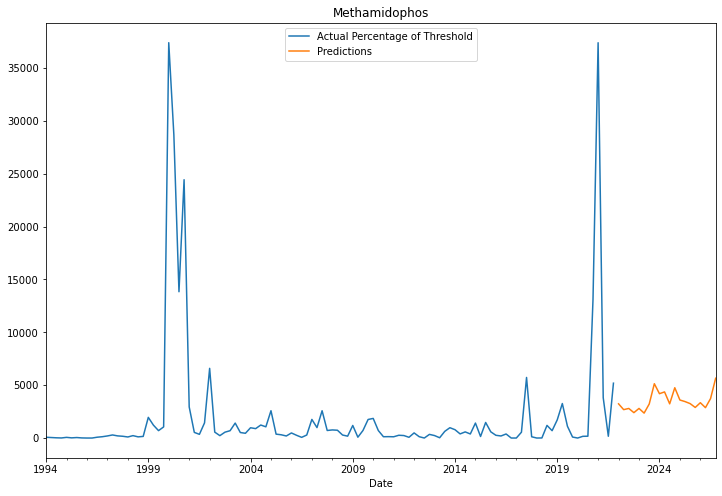

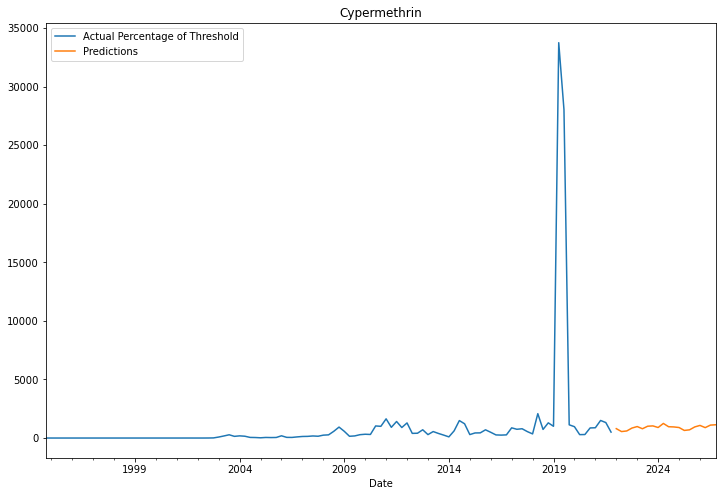

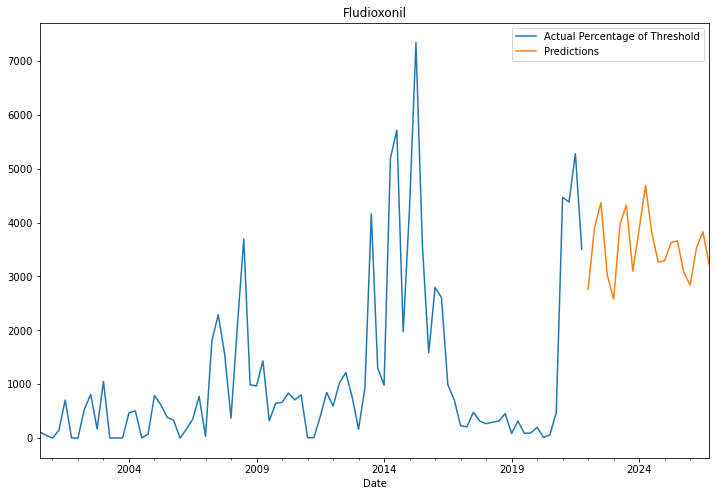

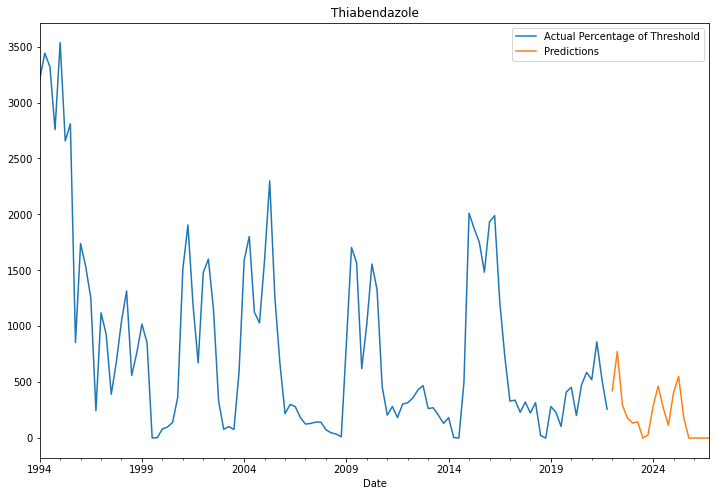

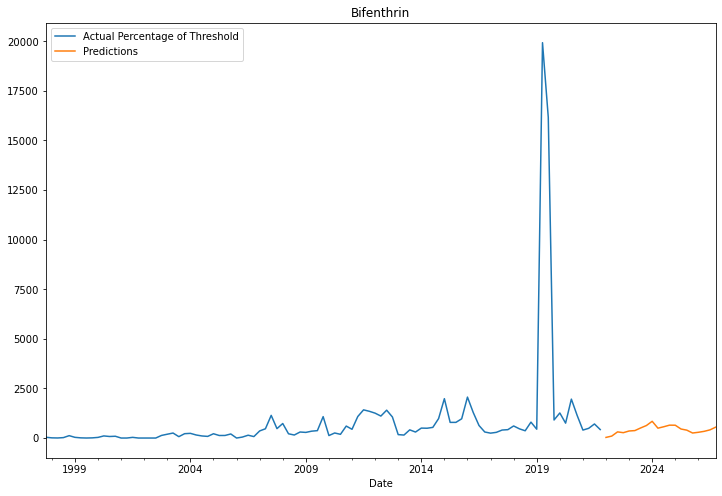

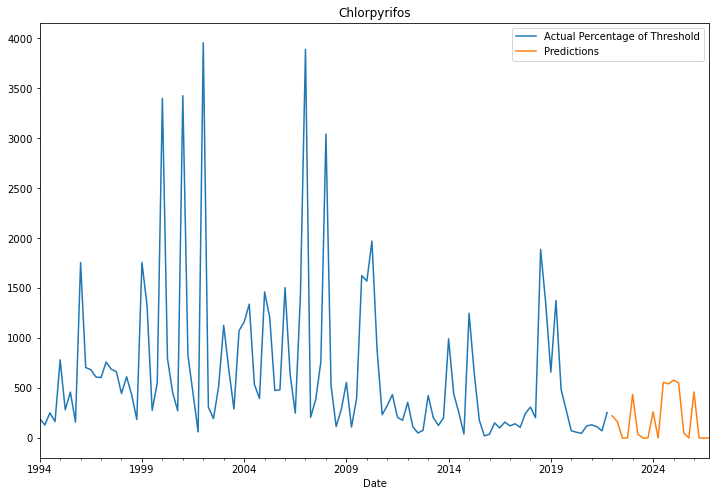

In [24]:
predictions = {}
for p in top_pest:
    top = data[data['Pesticide Name'] == p]
    top = top.set_index('Date')
    top = top.dropna()
    # create a time series with sesonal frequency
    ts = top['Percent of Threshold'].resample('Q').sum()
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ts.plot(label='Actual Percentage of Threshold')
    # get rid of outliers manually
    if p == 'Cypermethrin':
        ts['2019-06-30'] = 0
        ts['2019-09-30'] = 0
    if p == 'Acephate':
        ts['2021-03-31'] = 0
    if p == 'Acetamiprid':
        ts['2019-09-30'] = 0
        ts['2019-06-30'] = 0
    if p == 'Bifenthrin':
        ts['2019-09-30'] = 0
        ts['2019-06-30'] = 0
    if p == 'Methamidophos':
        ts['2021-03-31']=  0
    if p == 'Cyhalothrin, Total (Cyhalothrin-L + R157836 epimer)':
        ts['2019-09-30'] = 0
    ts.fillna(0, inplace=True) # replace the NaN values with 0
    model = auto_arima(ts,start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1,error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    model.fit(ts)
    preds = model.predict(n_periods=20)  #set the period to 5 years
    preds = preds.apply(lambda x: 0 if x < 0 else x)
    predictions[p] = preds
    preds.plot(label='Predictions')
    plt.legend()
    plt.title(p)
means = []
for p in predictions.values():
    m = p.mean()
    means.append(m)
results = pd.DataFrame(list(zip(top_pest, means)), columns=['Pesticide', 'Mean Percent of Threshold'])
results.sort_values(by='Mean Percent of Threshold',inplace=True,ascending=False)
results.reset_index(inplace=True)

In [25]:
results

,index,Pesticide,Mean Percent of Threshold
0,0,Acephate,13871.168350
1,5,Fludioxonil,3536.198095
2,3,Methamidophos,3498.949531
3,2,"Cyhalothrin, Total (Cyhalothrin-L + R157836 ep...",1980.019995
4,4,Cypermethrin,903.970653
5,1,Acetamiprid,657.235281
6,7,Bifenthrin,423.500281
7,6,Thiabendazole,211.929920
8,8,Chlorpyrifos,193.426987


### What products are these pesticides found in the most?

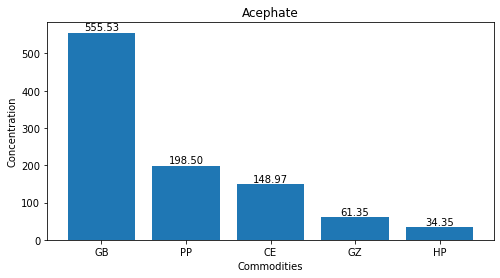

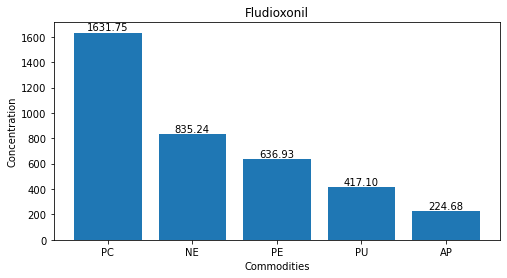

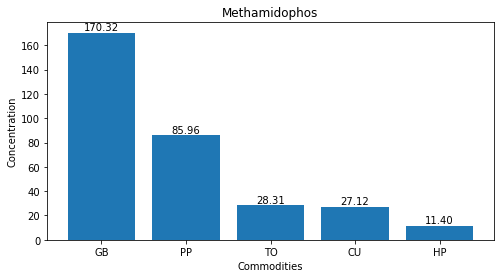

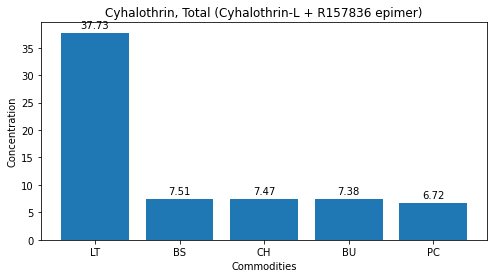

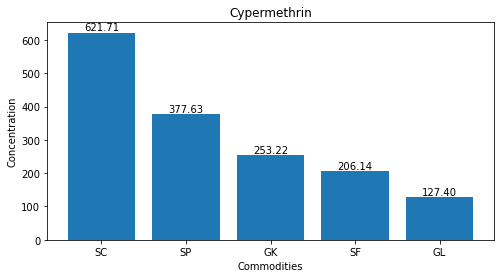

In [26]:
harmful = results['Pesticide'][:5].values
for i in harmful:
    pest = df[df['Pesticide Name'] == i]
    pest = pest.groupby('Commod')['Concentration'].sum()
    pest = pest.sort_values(ascending=False)
    pest = pest[:5]
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    plt.bar(pest.index.values, pest.values)
    plt.title(i)
    plt.xlabel("Commodities")
    plt.ylabel("Concentration")
    for i, v in enumerate(pest.values):
        plt.annotate("{:.2f}".format(v), xy=(i, v), xytext=(i, v+0.5),
                 ha='center', va='bottom')